# Sarcasm Detection with Bidirectional LSTM

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import Sequential,layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix ,classification_report

### Read 'Data.csv'

In [36]:
df=pd.read_csv('Data.csv')

In [37]:
df.head()

,headlines,target
0,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
1,"‘You Did The Best You Could,’ Says Iron Man Ac...",Sarcastic
2,New Emails Reveal Warm Relationship Between Ka...,Non Sarcastic
3,Donald Trump Jr. Gets Slammed Over Racist Birt...,Non Sarcastic
4,God Urges Rick Perry Not To Run For President,Sarcastic


### Print some of the Headlines along with the target

In [38]:
for i in range(10):
    print(df['headlines'][i] ,'--', df['target'][i])
    print()

CNN Triumphs (At Least in Most Demographic Categories) -- Non Sarcastic

‘You Did The Best You Could,’ Says Iron Man Action Figure Voiced By Despondent Toys ‘R’ Us CEO Packing Up Office -- Sarcastic

New Emails Reveal Warm Relationship Between Kamala Harris And Big Tech -- Non Sarcastic

Donald Trump Jr. Gets Slammed Over Racist Birtherism Bot Attack On Kamala Harris -- Non Sarcastic

God Urges Rick Perry Not To Run For President -- Sarcastic

Global Aid Pours into Haiti -- Non Sarcastic

CNN Anchor Calls Obama Protester 'Rude' And 'Crazy' -- Non Sarcastic

Federal Prisons Reinstitute Executions By Lethal Inflation -- Sarcastic

Lou Dobbs Crumbles When Pressed On His 'NAFTA Super Highway' Myth -- Non Sarcastic

CNN Still Bent On Debating 'Two Sides' Of The Confederacy -- Non Sarcastic



### Check Info

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12506 entries, 0 to 12505
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  12506 non-null  object
 1   target     12506 non-null  object
dtypes: object(2)
memory usage: 195.5+ KB


### View basic statistical information about the dataset

In [40]:
df.describe()

,headlines,target
count,12506,12506
unique,12506,2
top,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
freq,1,6531


### Check for missing values

In [41]:
df.isna().sum()

headlines    0
target       0
dtype: int64

### Check for duplicates

In [42]:
df.duplicated().sum()

0

### Plot a countplot of the Class Index

<Axes: xlabel='count', ylabel='target'>

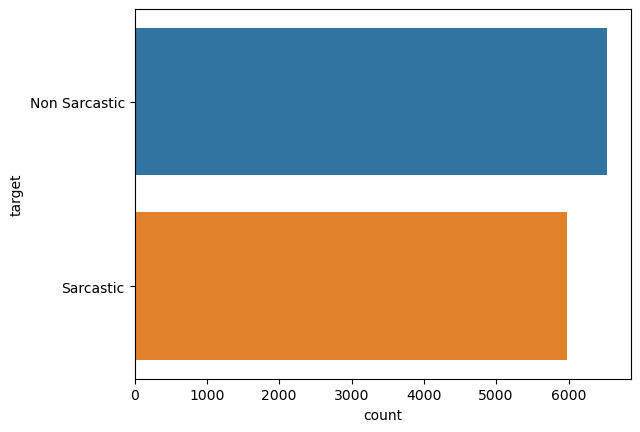

In [43]:
sns.countplot(y=df['target'])

### Create a funciton to preprocess the text

In [44]:
def preprocess(text):
    word=re.sub(r'[^a-zA-Z0-9]',' ',text).split()
    word=[i.lower() for i in word]
    lemma=WordNetLemmatizer()
    word=[lemma.lemmatize(i,'v') for i in word]
    return ' '.join(word)

### Apply the preprocess function to the description

In [45]:
df['headlines']=df['headlines'].apply(preprocess)

### Print some of the texts after the applying the function

In [46]:
for i in range(10):
    print(df['headlines'][i] ,'--', df['target'][i])
    print()

cnn triumph at least in most demographic categories -- Non Sarcastic

you do the best you could say iron man action figure voice by despondent toy r us ceo pack up office -- Sarcastic

new email reveal warm relationship between kamala harris and big tech -- Non Sarcastic

donald trump jr get slam over racist birtherism bot attack on kamala harris -- Non Sarcastic

god urge rick perry not to run for president -- Sarcastic

global aid pour into haiti -- Non Sarcastic

cnn anchor call obama protester rude and crazy -- Non Sarcastic

federal prisons reinstitute executions by lethal inflation -- Sarcastic

lou dobbs crumble when press on his nafta super highway myth -- Non Sarcastic

cnn still bend on debate two side of the confederacy -- Non Sarcastic



### Split Input & Target Variables

In [47]:
x=df['headlines']
y=df['target']

### One Hot encode our Target Variable

In [48]:
y.unique()

array(['Non Sarcastic', 'Sarcastic'], dtype=object)

In [49]:
from sklearn.preprocessing import LabelBinarizer

In [50]:
encoder=LabelBinarizer()

In [51]:
y=encoder.fit_transform(y)

### Split the dataset into Training & Testing Set

In [52]:
X_train, X_test,y_train,y_test = train_test_split(x,y, test_size = 0.2,random_state=100)

### Create a keras Tokenizer object

In the Keras library, the Tokenizer is a class that can be used to preprocess text data. It allows you to convert a collection of text documents into a numerical representation that can be used as input to a machine learning model.

In [53]:
tokenizer=Tokenizer(num_words=5000)


In [56]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

14122

### fit on text for our X

In [57]:
tokenizer.fit_on_texts(x)


### Create a function to convert text to numerical representation and add padding

In [58]:
def converttext(text):
    encode=tokenizer.texts_to_sequences(text)
    padding=pad_sequences(encode,maxlen=128)
    return padding
    
    

### Apply the function to our X_train & X_test

In [59]:
X_test=converttext(X_test)
X_train=converttext(X_train)

### Create keras Sequential model with BRNN Layers

In [60]:
import keras

In [61]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 128),
    keras.layers.Bidirectional(layers.LSTM(128,return_sequences=True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(layers.LSTM(128)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1807616   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

### Compile the model

In [63]:
model.compile(optimizer='adam' , loss='binary_crossentropy', metrics = ['accuracy'])

### Train the model with our Training Set

In [69]:
model.fit(X_train, y_train, epochs = 5, validation_split=0.05)

Epoch 1/5
297/297 [==============================] - 161s 541ms/step - loss: 0.2662 - accuracy: 0.8921 - val_loss: 0.2161 - val_accuracy: 0.9182
Epoch 2/5
297/297 [==============================] - 162s 547ms/step - loss: 0.1280 - accuracy: 0.9535 - val_loss: 0.2504 - val_accuracy: 0.9022
Epoch 3/5
297/297 [==============================] - 163s 547ms/step - loss: 0.0719 - accuracy: 0.9757 - val_loss: 0.2900 - val_accuracy: 0.9022
Epoch 4/5
297/297 [==============================] - 160s 540ms/step - loss: 0.0459 - accuracy: 0.9852 - val_loss: 0.3793 - val_accuracy: 0.8982
Epoch 5/5
297/297 [==============================] - 164s 552ms/step - loss: 0.0263 - accuracy: 0.9917 - val_loss: 0.4667 - val_accuracy: 0.8922


### Make predictions with Test set

In [70]:
pred = model.predict(X_test)

79/79 [==============================] - 12s 137ms/step


In [74]:
y_pred = [np.argmax(i) for i in pred]

### Check accuracy score

In [75]:
accuracy_score(y_test,y_pred)

0.5311750599520384

### Confusion matrix

<Axes: >

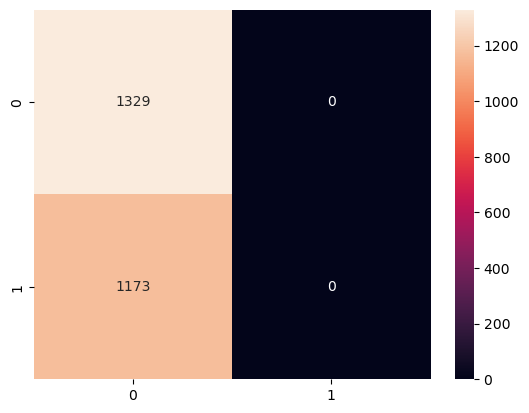

In [77]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

### Classification Report

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1329
           1       0.00      0.00      0.00      1173

    accuracy                           0.53      2502
   macro avg       0.27      0.50      0.35      2502
weighted avg       0.28      0.53      0.37      2502



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Email:shamilmskeeri@gmail.com

***